# Get the CMB-S4 sensitivity for polarised point sources.
## Goal is to do this on daily maps. Currently, this is just the coadd of E-maps.

In [8]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np, re, healpy as H, glob
import flatsky, tools

In [10]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'

In [11]:
#CMB-S4 PBDR configurations (Oct 2023) from https://docs.google.com/spreadsheets/d/10fL76XTzhgP_B_GKsEW4nqNTkRgvp2dh4zYh6Y-G2AE/edit#gid=0
specs_dic = {
#freq: [beam_arcmins, white_noise_T, elknee_T, alphaknee_T, whitenoise_P, elknee_P, alphaknee_P] 
27: [7.8, 27.1, 415., 3.5, 30.23 * (27.1/21.8), 700, 1.4],
39: [5.3, 11.6, 391., 3.5, 16.53 * (11.6/12.4), 700, 1.4], 
93: [2.2, 2.0, 1932., 3.5, 2.68, 700, 1.4],
145: [1.4, 2.0, 3917., 3.5, 2.96, 700, 1.4],
225: [1.0, 6.9, 6740., 3.5, 9.78, 700, 1.4],
278: [0.9, 16.7, 6792., 3.5, 23.93, 700, 1.4],
}
nu_arr = np.asarray( list( specs_dic.keys() ) )

In [12]:
#specs
lmax = 10000
el = np.arange(lmax+1)
band = 145
assert band in nu_arr

#sim specs
boxsize_am = 60. #1 degree box
x1, x2 = -boxsize_am/2, boxsize_am/2
dx = 0.25 #pixel size in arcmins
nx = ny = int( boxsize_am / dx)
mapparams = [ny, nx, dx]
noofsims = 2500 #for covariance calculation
ra = dec = np.linspace(x1, x2, nx)
ra_grid, dec_grid = np.meshgrid( ra, dec )

#flux to uK_CMB conversion
if dx == 0.5:
    conv_dic_jy_uk_cmb = {93: 221400.68750729345,
                           145: 122681.41947720562}
elif dx == 0.25:
    conv_dic_jy_uk_cmb = {93: 885602.7500291738,
                           145: 490725.6779088225}

#source
##source_pol_flux_in_uk = 200.
source_flux_mjy = 200.
source_pol_frac = 0.03 #3 per cent pol fraction
source_flux_jy = source_flux_mjy / 1e3
source_flux_in_uk = source_flux_jy * conv_dic_jy_uk_cmb[band]
source_pol_flux_in_uk = source_flux_in_uk * source_pol_frac
print( 'Source flux = %s mJy' %(source_flux_mjy) ) 
print( '\tTemperature = %s uK' %(source_flux_in_uk) ); 
print( '\tPolarisation intensity = %s uK for pol frac = %g\%%' %(source_pol_flux_in_uk, source_pol_frac*100.) ); 

#specs to get the radial profile for the source
binsize_am = 0.5 
maxbin_am = 3.

show_plot = True
if show_plot:
    fsval = 14

Source flux = 200.0 mJy
	Temperature = 98145.13558176451 uK
	Polarisation intensity = 2944.354067452935 uK for pol frac = 3\%


In [13]:
beam_arcmins, white_noise_T, elknee_T, alphaknee_T, whitenoise_P, elknee_P, alphaknee_P = specs_dic[band]


#get CMB Cl
camb_fname = 'data/cmb_spectra_lensed.npy'
camb_dic = np.load(camb_fname, allow_pickle=1).item()
el_camb = camb_dic['els']
cl_dic = camb_dic['Cl_dic']
cl_cmb_camb = cl_dic['EE']
cl_cmb = np.interp(el, el_camb, cl_cmb_camb, right = 0.) #being set to zero after el=7000 but does not really matter.

#get noise
nl = tools.get_nl(whitenoise_P, el, elknee = elknee_P, alphaknee = alphaknee_P, beamval = beam_arcmins)

#get beam
bl = flatsky.gauss_beam(beam_arcmins, lmax)

/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/pol_sources/tools.py:134: RuntimeWarning: divide by zero encountered in true_divide
  nl = np.copy(nl) * (1. + (elknee * 1./el)**alphaknee )


# Simulate a map and inject a source in it

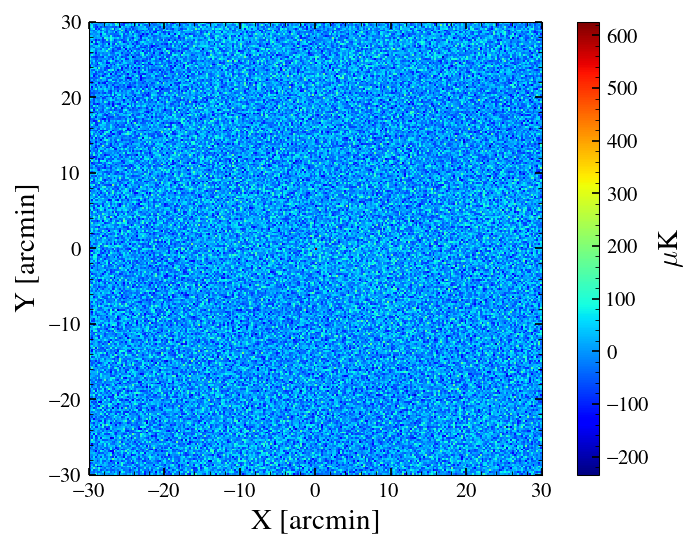

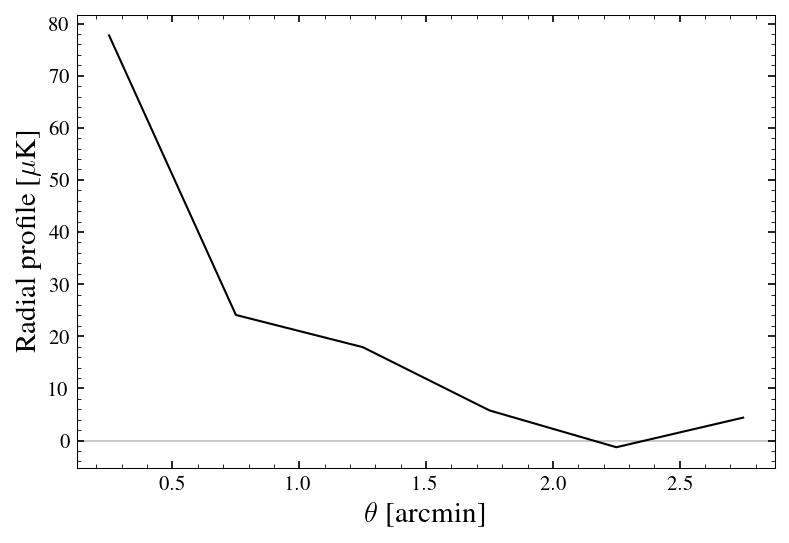

In [14]:
#cmb
cmb_sim_map = flatsky.make_gaussian_realisation(mapparams, el, cl_cmb)

#inject a source in it at the centre
source_sim_map = tools.inject_source_at_centre(mapparams, source_pol_flux_in_uk)

#signal map
signal_sim_map = cmb_sim_map + source_sim_map

#beam convolution
bl_2d = flatsky.cl_to_cl2d(el, bl, mapparams)
signal_sim_map = np.fft.ifft2( np.fft.fft2( signal_sim_map ) * bl_2d ).real

#noise
noise_sim_map = flatsky.make_gaussian_realisation(mapparams, el, nl)

#total
sim_map = signal_sim_map + noise_sim_map


#get radial profile of the signal sims
rad_prf_bins, sim_rad_prf = flatsky.radial_profile(sim_map, binsize=binsize_am, maxbin=maxbin_am, xy = (ra_grid, dec_grid))


if show_plot: #show map
    
    #sim map
    clf()
    imshow( sim_map, extent = [x1, x2, x1, x2] ); 
    cbar = colorbar(); cbar.set_label(r'$\mu$K', fontsize = fsval)
    xlabel(r'X [arcmin]', fontsize = fsval); ylabel(r'Y [arcmin]', fontsize = fsval)
    show()
    
    #radial profile
    clf()
    plot( rad_prf_bins, sim_rad_prf )
    xlabel(r'$\theta$ [arcmin]', fontsize = fsval)
    ylabel(r'Radial profile [$\mu$K]', fontsize = fsval)
    axhline(0., lw = 0.2)
    show()

# Get pixel-pixel covariance using simulations

In [15]:
rad_prf_bins, sim_cov = tools.get_pixel_pixel_covariance(mapparams, el, cl_cmb, nl, bl = bl, noofsims = noofsims, binsize_am = binsize_am, maxbin_am = maxbin_am)
print( sim_cov.shape )

(6, 6)


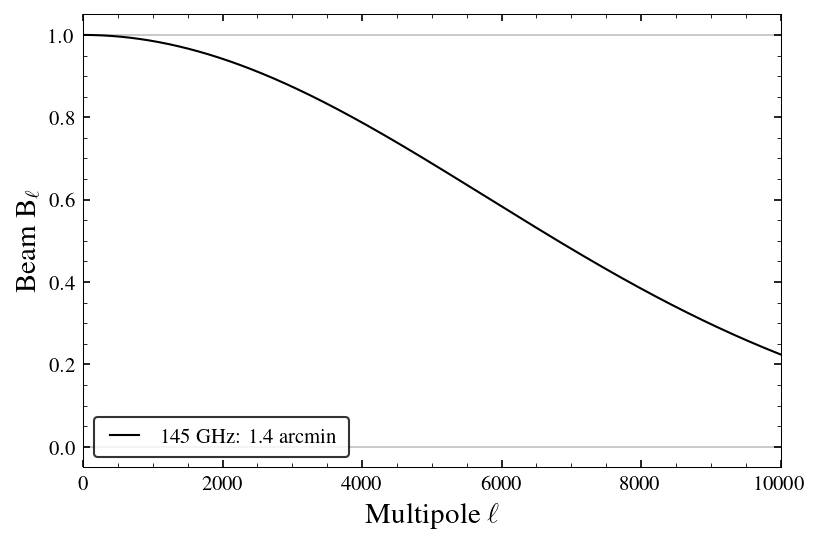

/var/folders/08/mkcy0rls72j2q09krs7qx2jw0000gn/T/ipykernel_24285/3034187516.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  xlim(0., lmax); ylim(-0.05, 1.05)


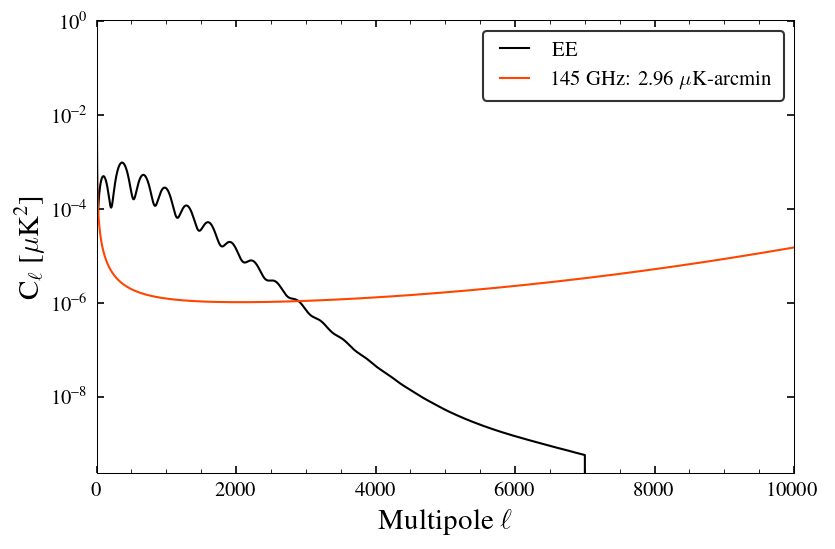

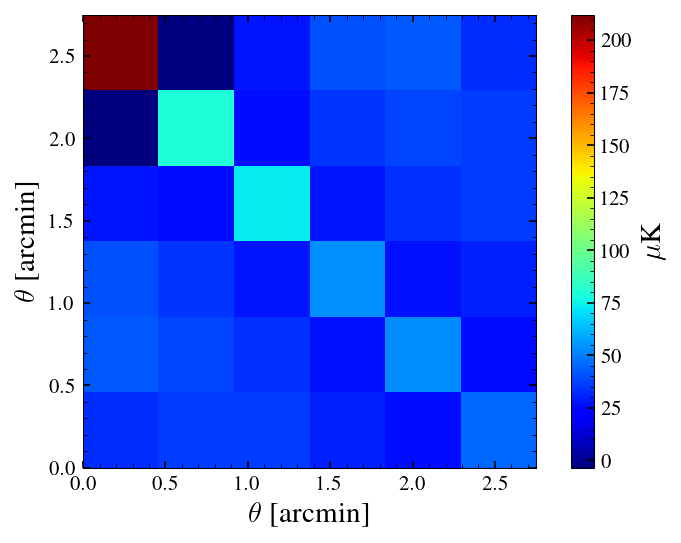

In [16]:
if show_plot:
    
    #beam
    clf()
    plot( el, bl, label = r'%s GHz: %s arcmin' %(band, beam_arcmins))
    axhline(0., lw = 0.2); axhline(1., lw = 0.2)
    xlim(0., lmax); ylim(-0.05, 1.05)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    ylabel(r'Beam B$_{\ell}$', fontsize = fsval)
    legend(loc = 3)
    show()    
    
    #CMB Cl and noise
    clf()
    ax = subplot(111, yscale = 'log')
    plot( el, cl_cmb, label = r'EE')
    plot( el, nl, color = 'orangered', label = r'%s GHz: %s $\mu$K-arcmin' %(band, whitenoise_P))
    xlim(0., lmax); ylim(-0.05, 1.05)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    ylabel(r'C$_{\ell}$ [$\mu$K$^{2}$]', fontsize = fsval)
    legend(loc = 1)
    show()
    
    #pixel-pixel covariance
    clf()
    imshow( sim_cov, extent = [0, max(rad_prf_bins), 0, max(rad_prf_bins)]); 
    cbar = colorbar()
    cbar.set_label(r'$\mu$K', fontsize = fsval)
    xlabel(r'$\theta$ [arcmin]', fontsize = fsval); ylabel(r'$\theta$ [arcmin]', fontsize = fsval)
    show()

# Likelihood

/Users/sraghunathan/Research/SPTpol/analysis/git/DRAFT/pol_sources/flatsky.py:473: RuntimeWarning: invalid value encountered in double_scalars
  std_mean = np.sum(errors * hits) / np.sum(hits)


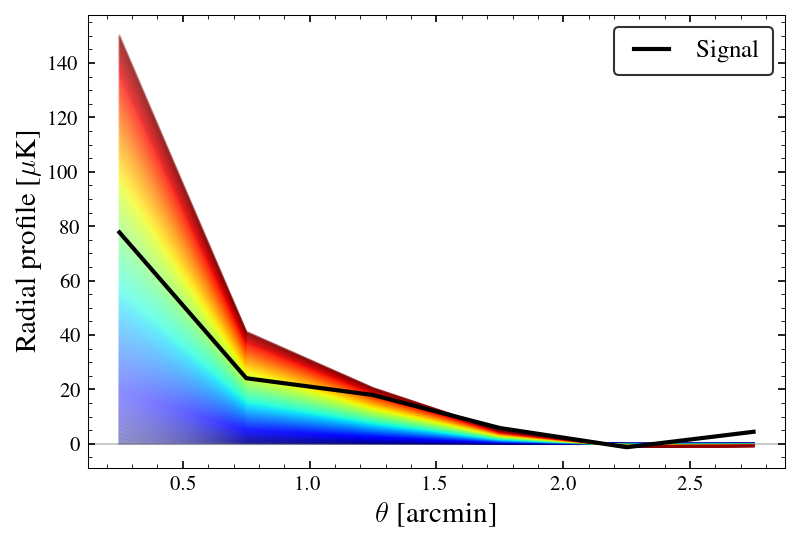



10.783367576200858
10.783367576200858


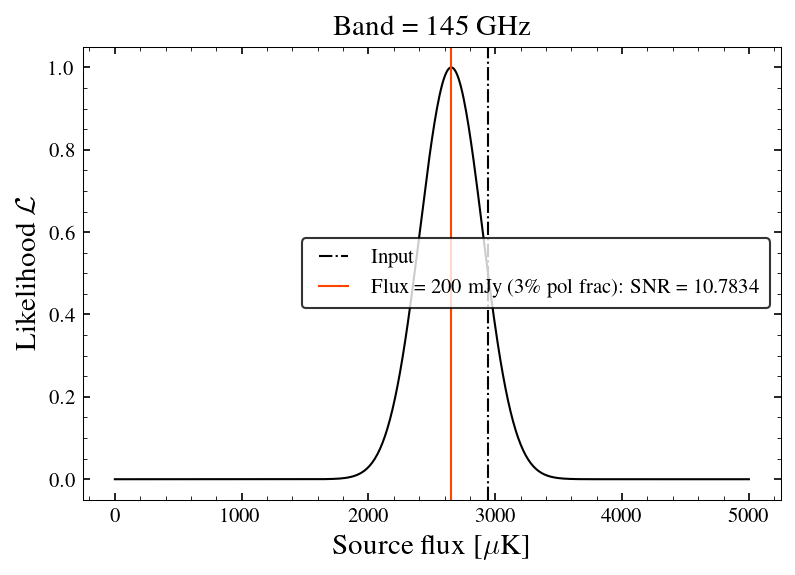

In [19]:
model_source_pol_flux_in_uk_arr = np.arange(0., 5001., 10.)
loglarr = []
color_arr = [cm.jet(int(d)) for d in np.linspace(0, 255, len(model_source_pol_flux_in_uk_arr))]
if show_plot:
    clf()
    ax = subplot(111)
for cntr, model_source_pol_flux_in_uk in enumerate( model_source_pol_flux_in_uk_arr ):
    #print( model_source_pol_flux_in_uk, end = '\t')
    
    #source model
    model_source_sim_map = tools.inject_source_at_centre(mapparams, model_source_pol_flux_in_uk)
    #beam
    model_source_sim_map = np.fft.ifft2( np.fft.fft2( model_source_sim_map ) * bl_2d ).real
    ##imshow(model_source_sim_map); colorbar(); show(); sys.exit()

    #radial profile
    rad_prf_bins, model_rad_prf = flatsky.radial_profile(model_source_sim_map, binsize=binsize_am, maxbin=maxbin_am, xy = (ra_grid, dec_grid))

    #likelihood
    curr_loglval = tools.get_likelihood(sim_rad_prf, model_rad_prf, sim_cov)
    ##print( model_source_pol_flux_in_uk, curr_loglval)
    loglarr.append( curr_loglval )
    
    if show_plot:
        plot( rad_prf_bins, model_rad_prf, color = color_arr[cntr], alpha = 0.2)
        
if show_plot:
    plot( rad_prf_bins, sim_rad_prf, lw = 2., label = r'Signal' )
    legend(loc = 1, fontsize = fsval - 2)
    xlabel(r'$\theta$ [arcmin]', fontsize = fsval)
    ylabel(r'Radial profile [$\mu$K]', fontsize = fsval)
    axhline(0., lw = 0.2)
    show()
    
print('\n')
loglarr = np.asarray( loglarr) 
xarr, larr, recov_source_flux, snr = tools.lnlike_to_like(model_source_pol_flux_in_uk_arr, loglarr ) 
print( snr )
delta_chisq = max(loglarr) - loglarr[0]
snr = np.sqrt(delta_chisq*2.)
print( snr )

labval = r'Flux = %g mJy (%g\%% pol frac): SNR = %g' %(source_flux_mjy, source_pol_frac*100., snr)

clf()
plot( model_source_pol_flux_in_uk_arr, larr )
axvline(source_pol_flux_in_uk, color = 'black', ls = '-.', label = r'Input')
axvline(recov_source_flux, color = 'orangered', label = labval) ##r'Recovered: SNR = $%.1f$' %(snr))
xlabel(r'Source flux [$\mu$K]', fontsize = fsval)
ylabel(r'Likelihood $\mathcal{L}$', fontsize = fsval)
legend(loc = 'best', fontsize = fsval - 4)
title(r'Band = %s GHz' %(band), fontsize = fsval)
show()